# Conversion of Jump-start R program provided by Dr. Thomas Miller.

## Applied the Monte Carlo Simulation Method to a Personal ETF portfolio optimization problem. The Sharpe Ratio and target weights between the two schemes, Long Only and Shorts OK, have been compared

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal

In [2]:
# Calculate covariance Matrix from given standard deviation and correlation matrix

def cov_from_sd_corr(sd, corr):
    """Build covariance matrix from SD vector and correlation matrix."""
    print(f"Input 1: SD array:\n {sd}")
    print(f"Input 2: Correlation Matrix:\n {corr}")
    D = np.diag(sd)
    print (f"Diagonal Matix D created from SD:\n {D}")
    print (f"first step calculate: D @ corr: \n {D @ corr}")
    return D @ corr @ D


In [3]:
def make_weights(n_assets, shorts_ok=True, rng=None):
    """Return a single weight vector that sums to 1.
       If shorts_ok True, generate (n-1) uniform(-1,1) and set nth = 1 - sum(n-1).
       If shorts_ok False, generate uniform(0,1) and normalize.
    """
    if rng is None:
        rng = np.random
    if shorts_ok:
        # Generate n-1 weights, then calculate the last one
        first_n_minus_1 = rng.uniform(-1, 1, size=n_assets-1)
        last_weight = 1.0 - first_n_minus_1.sum()
        w = np.concatenate([first_n_minus_1, [last_weight]])
    else:
        raw = rng.uniform(0, 1, size=n_assets)
        w = raw / raw.sum()
    return w

In [4]:
def simulate_returns(mu, cov, sample_size=700, seed=None):
    """Simulate multivariate normal returns (sample_size x n_assets)."""
    rng = np.random.default_rng(seed)
    return rng.multivariate_normal(mean=mu, cov=cov, size=sample_size)

In [5]:
def evaluate_portfolios(returns, weights_matrix, cov_matrix, rf=0.0):
    """Compute portfolio return series, mean, sd, Sharpe, CVaR (95) for each weight set."""
    n_portfolios = weights_matrix.shape[0]
    n_assets = weights_matrix.shape[1]  # FIX: Get number of assets dynamically
    results = []
    
    for i in range(n_portfolios):
        w = weights_matrix[i]
        port_returns = returns @ w  # shape (T,)
        mean_ret = port_returns.mean()
        sd_ret = port_returns.std(ddof=1)
        sharpe = (mean_ret - rf) / sd_ret if sd_ret > 0 else np.nan
        # VaR (5% quantile) and CVaR (average of losses <= VaR)
        var_95 = np.percentile(port_returns, 5)
        cvar_95 = port_returns[port_returns <= var_95].mean() if np.any(port_returns <= var_95) else var_95
        # theoretical sigma via w' Sigma w as cross-check
        theo_sd = np.sqrt(w.T @ cov_matrix @ w)
        
        # FIX: Create weight dictionary dynamically
        weight_dict = {f"w{j+1}": w[j] for j in range(n_assets)}
        
        result = {
            **weight_dict,  # Unpack all weights
            "has_shorts": int(np.any(w < 0)),
            "mean": mean_ret,
            "sd_sample": sd_ret,
            "sd_theoretical": theo_sd,
            "sharpe": sharpe,
            "var_95": var_95,
            "cvar_95": cvar_95
        }
        results.append(result)
    return pd.DataFrame(results)

In [6]:
def run_experiment(mu, sd, corr, sample_size=700, n_weights=700, seed_returns=1111, seed_weights=9999):
    """Run Monte Carlo: simulate returns, generate weight sets (shorts and no-shorts),
       evaluate portfolios and return combined results for both regimes.
    """
    n_assets = len(mu)  # FIX: Get number of assets dynamically
    
    cov = cov_from_sd_corr(sd, corr)
    returns = simulate_returns(mu, cov, sample_size=sample_size, seed=seed_returns)  # (T,N)
    data_cov = np.cov(returns, rowvar=False)

    # generate weights
    rng = np.random.default_rng(seed_weights)
    weights_shorts = np.vstack([make_weights(n_assets, shorts_ok=True, rng=rng) for _ in range(n_weights)])
    rng2 = np.random.default_rng(seed_weights)  # same seed to keep parallel structure
    weights_long = np.vstack([make_weights(n_assets, shorts_ok=False, rng=rng2) for _ in range(n_weights)])

    # evaluate long only
    res_long = evaluate_portfolios(returns, weights_long, data_cov)
    res_long["regime"] = "Long Positions Only"

    # evaluate shorts ok
    res_shorts = evaluate_portfolios(returns, weights_shorts, data_cov)
    res_shorts["regime"] = "Shorts OK"

    # attach sample statistics
    sample_stats = {
        "returns_sim_mean": returns.mean(axis=0),
        "returns_sim_sd": returns.std(axis=0, ddof=1),
        "data_cov_matrix": data_cov
    }
    return pd.concat([res_long, res_shorts], ignore_index=True), sample_stats

In [7]:
def plot_results(df, title=None):
    df_plot = df.copy()
    df_plot["sd"] = df_plot["sd_sample"]
    df_plot["mean_return"] = df_plot["mean"]
    df_plot["short_flag"] = df_plot["has_shorts"].map({0:"No Shorts", 1:"Has Shorts"})
    print("Counts of short_flag within each regime:")
    print(df_plot.groupby("regime")["short_flag"].value_counts())
    # add scenario label from caller: caller should add 'scenario' column
    color_map = {"No Shorts": "darkblue", "Has Shorts": "red"}
    g = sns.FacetGrid(df_plot, row="scenario", col="regime", height=4, sharex=True, sharey=True)
    g.map_dataframe(sns.scatterplot, x="sd", y="mean_return", hue="short_flag", s=20, palette=color_map, alpha=0.7)
    g.set_axis_labels("Risk: Standard Deviation of Portfolio Returns", "Return: Mean of Portfolio Returns")
    if title:
        plt.subplots_adjust(top=0.9); g.fig.suptitle(title)
    return g

<>:7: SyntaxWarning: invalid escape sequence '\M'
<>:7: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Sujala\AppData\Local\Temp\ipykernel_28572\3833356063.py:7: SyntaxWarning: invalid escape sequence '\M'
  df = pd.read_csv("..\MSDS-451-TermProject\selected_portfolio_weights.csv")


Column structure sample: [('Adj Close', 'AAPL'), ('Adj Close', 'ABBV'), ('Adj Close', 'AMD'), ('Adj Close', 'AMZN'), ('Adj Close', 'AVGO'), ('Adj Close', 'CME'), ('Adj Close', 'COST'), ('Adj Close', 'FDIVX'), ('Adj Close', 'FXY'), ('Adj Close', 'GLD'), ('Adj Close', 'GOOG'), ('Adj Close', 'HD'), ('Adj Close', 'INTC'), ('Adj Close', 'KO'), ('Adj Close', 'META'), ('Adj Close', 'MSFT'), ('Adj Close', 'NVDA'), ('Adj Close', 'PEP'), ('Adj Close', 'PFE'), ('Adj Close', 'PG')]
Final price columns: ['AAPL', 'ABBV', 'AMD', 'AMZN', 'AVGO', 'CME', 'COST', 'FDIVX', 'FXY', 'GLD', 'GOOG', 'HD', 'INTC', 'KO', 'META', 'MSFT', 'NVDA', 'PEP', 'PFE', 'PG', 'SCHD', 'SLV', 'SPLB', 'TLT', 'VDE', 'VEA', 'VWO', 'VYM', 'WMT', 'XOM']


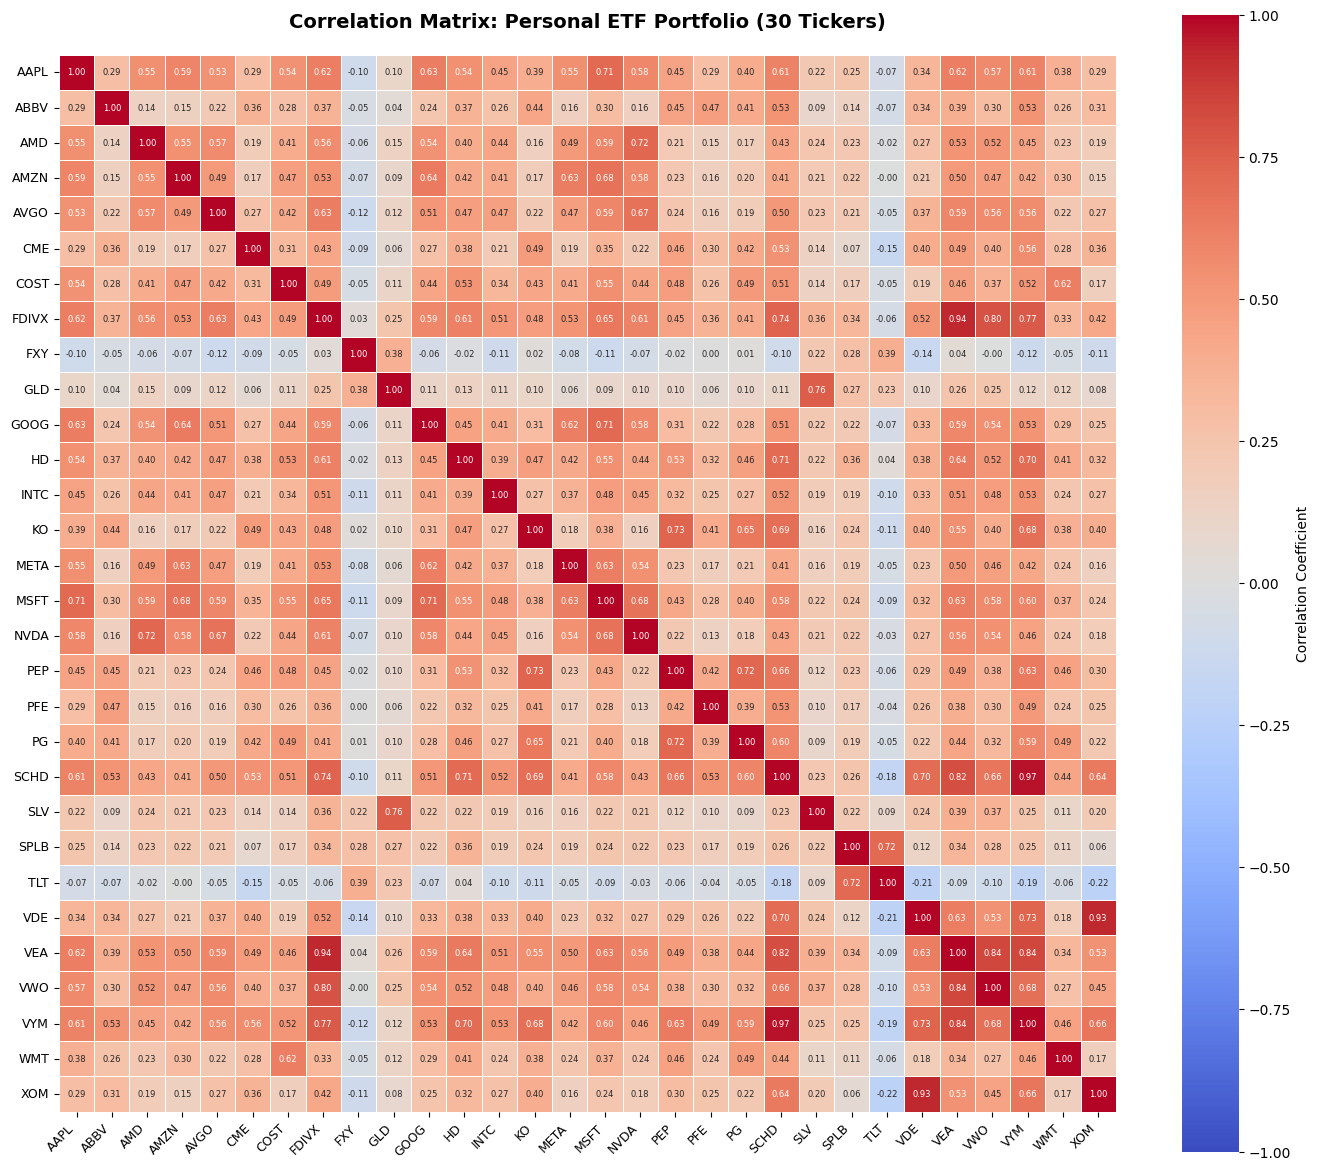

In [8]:
# -------------------------
# Scenario 1: Personal ETF
# -------------------------
import yfinance as yf
import pandas as pd

df = pd.read_csv("..\MSDS-451-TermProject\selected_portfolio_weights.csv")
tickers = df['Ticker'].tolist()
# choose tickers for your 4-asset portfolio (change as desired)
# tickers = ["FXAIX", "QQQM", "SCHD", "SFLNX"]

# Portfolio of 30 tickers including tech, consumer, energy, ETFs, bonds, gold, forex
# tickers = ['AAPL', 'GOOG', 'MSFT', 'NVDA', 
#            'AMZN', 'AMD', 'INTC', 'META',
#            'COST', 'PG', 'KO', 'PEP', 'WMT',
#            'CME', 'AVGO', 'PFE', 'ABBV', 'HD', 
#            'XOM', 'VDE',
#            'SCHD', 'VYM', 
#            'VWO', 'VEA',
#            'GLD', 'SLV',
#            'FXY', 'FDIVX',
#            'TLT', 'SPLB']

# date range for estimating parameters (at least 5 years recommended)
start_date = "2020-01-01"
end_date = "2025-10-31"
# try downloading (auto_adjust=False so "Adj Close" may appear)
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)

# inspect columns if something unexpected happens
print("Column structure sample:", list(data.columns[:20]))

# robust extraction of adjusted close prices
if isinstance(data.columns, pd.MultiIndex):
    # prefer level=0='Adj Close' if present, else try level=1
    if 'Adj Close' in data.columns.levels[0]:
        prices = data.xs('Adj Close', axis=1, level=0).dropna()
    elif 'Adj Close' in data.columns.levels[1]:
        prices = data.xs('Adj Close', axis=1, level=1).dropna()
    else:
        # fallback to 'Close' fields
        if 'Close' in data.columns.levels[0]:
            prices = data.xs('Close', axis=1, level=0).dropna()
        else:
            # flatten and attempt to pick ticker columns
            flat = pd.DataFrame({ (col[-1] if isinstance(col, tuple) else col): data[col] for col in data.columns })
            prices = flat.loc[:, flat.columns.intersection(tickers)].dropna()
else:
    # single-level columns: might already be tickers or 'Adj Close' absent
    if set(tickers).issubset(data.columns):
        prices = data.loc[:, tickers].dropna()
    elif 'Adj Close' in data.columns:
        prices = data['Adj Close'].dropna()
    else:
        # try any column containing 'Close'
        close_cols = [c for c in data.columns if 'Close' in str(c)]
        if close_cols:
            prices = data[close_cols].dropna()
        else:
            raise RuntimeError("Could not locate price columns in downloaded data; inspect data.columns")

# normalize column names to tickers (handles tuples)
prices.columns = [c if not isinstance(c, tuple) else c[-1] for c in prices.columns]
print("Final price columns:", list(prices.columns))

# compute daily simple returns
daily_ret = prices.pct_change().dropna()

# trading days per year (use 252 for US markets)
trading_days = 252

# Option A: arithmetic annualization (common, simple)
mean_daily = daily_ret.mean()
mu_annual = mean_daily * trading_days        # approximate expected annual return
sd_daily = daily_ret.std(ddof=1)
sd_annual = sd_daily * np.sqrt(trading_days) # annualized volatility

# correlation matrix (use daily returns)
corr_matrix = daily_ret.corr()

# convert to numpy arrays used by the notebook functions
mu2 = mu_annual.to_numpy()
sd2 = sd_annual.to_numpy()
corr2 = corr_matrix.to_numpy()

# Plot the correlation matrix as a seaborn heatmap with ticker labels
plt.figure(figsize=(14, 12))
sns.heatmap(corr2, 
            annot=True,           # CHANGED: Show correlation values
            fmt='.2f',            # ADDED: Format to 2 decimal places
            cmap='coolwarm',      # Color scheme (blue-red)
            center=0,             # Center colormap at 0
            square=True,          # Make cells square
            linewidths=0.5,       # Add gridlines
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=-1, vmax=1,      # Set scale from -1 to 1
            xticklabels=tickers,  # Use ticker names for x-axis
            yticklabels=tickers,  # Use ticker names for y-axis
            annot_kws={'fontsize': 6})  # ADDED: Smaller font for numbers

plt.title('Correlation Matrix: Personal ETF Portfolio (30 Tickers)', 
          fontsize=14, fontweight='bold', pad=20)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('correlation_matrix_heatmap_30tickers.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
res2, stats2 = run_experiment(mu2, sd2, corr2,
                              sample_size=700, n_weights=700,
                              seed_returns=2222, seed_weights=8888)

Input 1: SD array:
 [0.32183268 0.2496266  0.53897213 0.35734031 0.43644601 0.26898022
 0.23906924 0.19642583 0.10019433 0.16279062 0.32361964 0.28038319
 0.47339109 0.20440523 0.44240892 0.29786346 0.53583251 0.2230168
 0.27316626 0.20665811 0.1956416  0.31292405 0.15678098 0.17303556
 0.35220908 0.19651103 0.20873361 0.19204363 0.2299174  0.33141131]
Input 2: Correlation Matrix:
 [[ 1.00000000e+00  2.92602702e-01  5.47802931e-01  5.94928926e-01
   5.33169927e-01  2.90862007e-01  5.38368940e-01  6.24779289e-01
  -9.76761219e-02  1.04638354e-01  6.28910827e-01  5.42524975e-01
   4.48062537e-01  3.92898040e-01  5.53204147e-01  7.14415792e-01
   5.82945544e-01  4.46250718e-01  2.86068885e-01  4.02609869e-01
   6.06312462e-01  2.21648721e-01  2.47426615e-01 -6.80749145e-02
   3.44809832e-01  6.19557518e-01  5.73564116e-01  6.06575693e-01
   3.79470212e-01  2.92996681e-01]
 [ 2.92602702e-01  1.00000000e+00  1.42414560e-01  1.48950210e-01
   2.17414531e-01  3.62278571e-01  2.81004501e-01  3

Counts of short_flag within each regime:
regime               short_flag
Long Positions Only  No Shorts     700
Shorts OK            Has Shorts    700
Name: count, dtype: int64


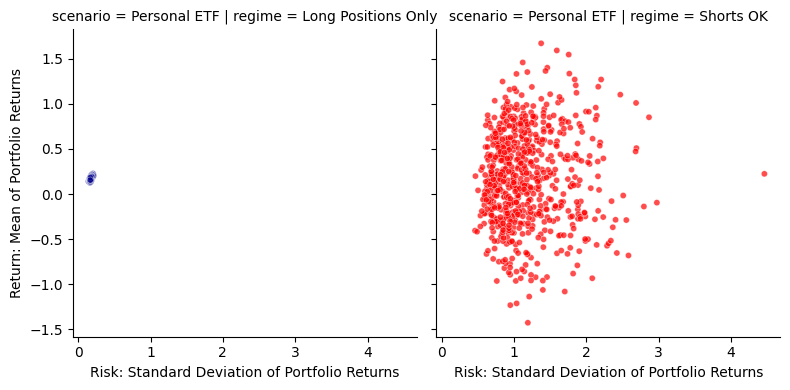

In [10]:
res2["scenario"] = "Personal ETF"
g = plot_results (res2)
g.savefig("portfolio_results_scenario2.png")

In [11]:
print("Top 10 portfolios by Sharpe Ratio:")
display(res2.sort_values(by="sharpe", ascending=False).head(10))

Top 10 portfolios by Sharpe Ratio:


,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,...,w30,has_shorts,mean,sd_sample,sd_theoretical,sharpe,var_95,cvar_95,regime,scenario
747,-0.531499,0.875178,0.094141,-0.565186,0.145389,-0.680083,0.624449,-0.245971,-0.371348,0.404292,...,-0.356058,1,1.246659,0.841425,0.841425,1.481604,-0.193799,-0.451948,Shorts OK,Personal ETF
972,0.498354,-0.030256,-0.298665,-0.631747,0.980101,-0.846749,0.801021,0.206972,-0.435973,-0.733956,...,-0.210617,1,1.033468,0.733821,0.733821,1.408338,-0.136902,-0.479331,Shorts OK,Personal ETF
1051,-0.413078,0.436469,0.040492,-0.257400,-0.537335,-0.217620,0.957028,-0.838754,-0.095713,0.225205,...,0.472796,1,0.873113,0.636268,0.636268,1.372240,-0.147046,-0.412783,Shorts OK,Personal ETF
835,0.572706,0.757693,-0.223288,-0.004492,0.588392,-0.625719,0.268108,0.432066,0.283040,0.142572,...,0.639023,1,1.457982,1.120751,1.120751,1.300898,-0.406916,-0.840524,Shorts OK,Personal ETF
1323,-0.917342,0.012735,0.673742,-0.276873,0.801047,0.236842,-0.367694,-0.659932,-0.808201,-0.264728,...,-0.140899,1,1.330925,1.033564,1.033564,1.287704,-0.381564,-0.750139,Shorts OK,Personal ETF
941,0.653259,0.237137,0.371856,0.331535,0.113897,-0.775094,-0.920862,-0.097433,0.840927,0.966468,...,1.106583,1,0.819911,0.638045,0.638045,1.285037,-0.252879,-0.485460,Shorts OK,Personal ETF
1073,-0.650989,0.973078,0.342866,-0.057347,0.230940,0.014772,0.386084,0.624821,0.405850,0.488342,...,0.114013,1,0.761703,0.611189,0.611189,1.246263,-0.223341,-0.518015,Shorts OK,Personal ETF
774,-0.115452,0.849027,0.540767,-0.255153,0.766535,-0.216475,0.698212,-0.267648,-0.945918,0.249899,...,2.183672,1,1.156714,0.939239,0.939239,1.231545,-0.350881,-0.619372,Shorts OK,Personal ETF
780,-0.388531,0.340031,-0.590961,0.181948,0.737970,-0.125604,-0.806144,-0.134254,-0.380198,0.908426,...,1.089295,1,1.070140,0.879893,0.879893,1.216216,-0.335295,-0.671788,Shorts OK,Personal ETF
1000,0.334783,-0.654965,0.750100,-0.072096,0.155101,-0.011272,0.139932,0.299256,-0.915084,-0.007664,...,3.548808,1,1.669944,1.374928,1.374928,1.214569,-0.486817,-0.937291,Shorts OK,Personal ETF


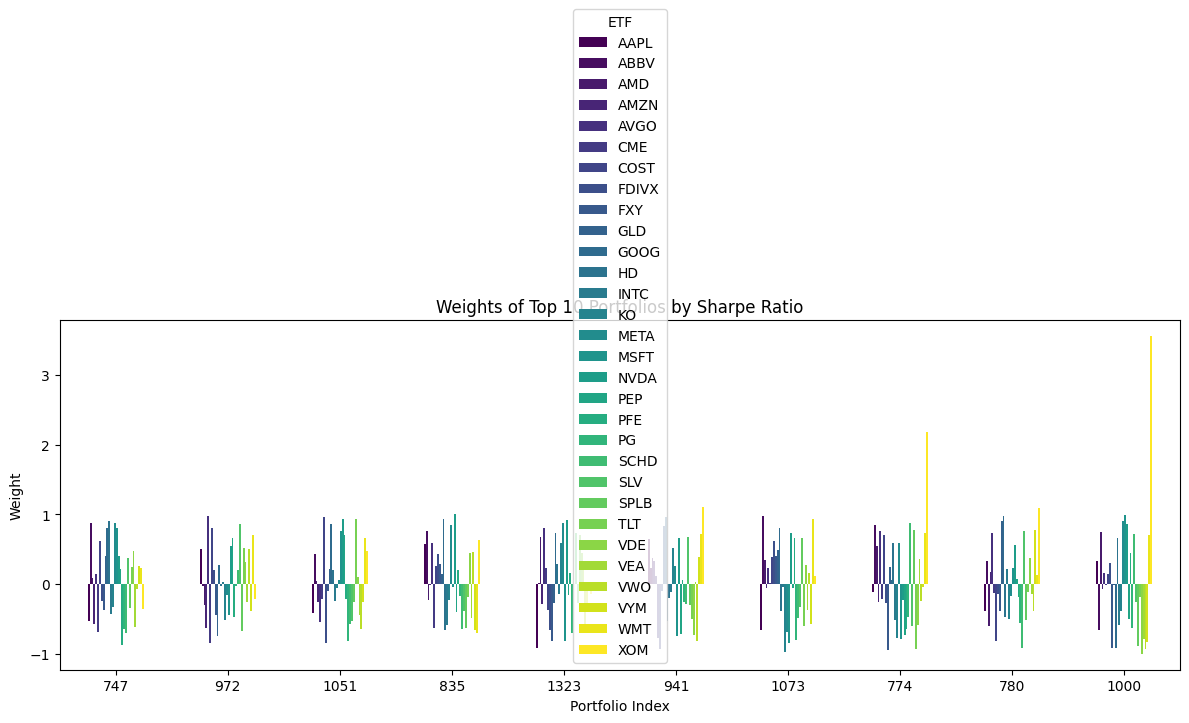

In [12]:
import matplotlib.pyplot as plt

top_10_portfolios = res2.sort_values(by="sharpe", ascending=False).head(10)

# Select only the weight columns
weights_df = top_10_portfolios[[col for col in res2.columns if col.startswith('w')]]

# Rename columns for better plotting labels
weights_df.columns = [tickers[i] for i in range(len(weights_df.columns))]

# Plotting the weights
ax = weights_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')

plt.title('Weights of Top 10 Portfolios by Sharpe Ratio')
plt.xlabel('Portfolio Index')
plt.ylabel('Weight')
plt.xticks(rotation=0)
plt.legend(title='ETF')
plt.tight_layout()
plt.show()

In [13]:
# Assuming the 700 simulation periods represent 700 trading days
sim_periods = 1000
trading_days_in_year = 252

# Calculate annualized mean returns for each portfolio in res2
res2["mean_annualized_simulated"] = res2["mean"] * (trading_days_in_year / sim_periods)

print("Simulated Mean Returns (over 700 periods) vs. Annualized Simulated Mean Returns:")
display(res2[["mean", "mean_annualized_simulated"]].head())

# Optionally, you can also display the top portfolios with their annualized simulated returns
print("\nTop 10 portfolios by  Annualized Simulated Mean Return:")
display(res2.sort_values(by="mean", ascending=False).head(10)[["w1", "w2", "w3", "w4", "mean", "mean_annualized_simulated", "sharpe"]])

Simulated Mean Returns (over 700 periods) vs. Annualized Simulated Mean Returns:


,mean,mean_annualized_simulated
0,0.157824,0.039772
1,0.160760,0.040511
2,0.158731,0.040000
3,0.173063,0.043612
4,0.168708,0.042514



Top 10 portfolios by  Annualized Simulated Mean Return:


,w1,w2,w3,w4,mean,mean_annualized_simulated,sharpe
1000,0.334783,-0.654965,0.750100,-0.072096,1.669944,0.420826,1.214569
789,0.614281,-0.886627,-0.173410,0.519405,1.591055,0.400946,0.999536
1032,-0.552762,0.273307,0.417495,-0.939612,1.544804,0.389291,0.879622
835,0.572706,0.757693,-0.223288,-0.004492,1.457982,0.367411,1.300898
732,-0.692296,-0.352923,0.410243,0.253531,1.399461,0.352664,0.958537
1176,-0.414756,0.153464,-0.051179,0.475953,1.363567,0.343619,0.949787
1201,-0.505290,-0.126094,0.750370,-0.657120,1.351418,0.340557,1.141295
984,-0.314804,0.589668,0.867170,0.677231,1.333976,0.336162,0.756013
1323,-0.917342,0.012735,0.673742,-0.276873,1.330925,0.335393,1.287704
724,-0.506173,-0.324195,0.775276,0.034241,1.268998,0.319788,0.689997


In [14]:
# Detect the points that make the Efficient Frontier for the Portfolio
efficient_frontier_portfolios_list = []

for i in range(len(res2)):
  is_on_frontier = True
  portfolio_to_check = res2.iloc[i]

  for j in range(len(res2)):
      if i != j:
          other_portfolio = res2.iloc[j]
          # Check if other_portfolio dominates portfolio_to_check
          if (other_portfolio["sd_sample"] <= portfolio_to_check["sd_sample"] and other_portfolio["mean"] > portfolio_to_check["mean"]) or \
            (other_portfolio["sd_sample"] < portfolio_to_check["sd_sample"] and other_portfolio["mean"] >= portfolio_to_check["mean"]):
              is_on_frontier = False
              break

  if is_on_frontier:
      # If on the frontier, add the portfolio (as a Series or dictionary) to the list
      efficient_frontier_portfolios_list.append(portfolio_to_check)
      #print(f"Portfolio at index {i} is on the simulated efficient frontier.")
  #else:
  #    print(f"Portfolio at index {i} is NOT on the simulated efficient frontier.")

# Convert the list of efficient frontier portfolios into a DataFrame
ef_frame = pd.DataFrame(efficient_frontier_portfolios_list)


print("Efficient Frontier Portfolios:")
display(ef_frame)


Efficient Frontier Portfolios:


,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,...,has_shorts,mean,sd_sample,sd_theoretical,sharpe,var_95,cvar_95,regime,scenario,mean_annualized_simulated
47,0.002128,0.061624,0.002338,0.003999,0.031631,0.018918,0.060697,0.028708,0.048027,0.027344,...,0,0.170849,0.161800,0.161800,1.055928,-0.103933,-0.177979,Long Positions Only,Personal ETF,0.043054
87,0.017213,0.045742,0.002843,0.016292,0.044749,0.036523,0.042000,0.049760,0.025558,0.046330,...,0,0.184559,0.170689,0.170689,1.081259,-0.103063,-0.174713,Long Positions Only,Personal ETF,0.046509
151,0.011693,0.048707,0.036272,0.056594,0.033800,0.006785,0.011523,0.017003,0.066520,0.022258,...,0,0.149144,0.152777,0.152777,0.976221,-0.101828,-0.169128,Long Positions Only,Personal ETF,0.037584
290,0.048181,0.012454,0.063172,0.033494,0.041695,0.035689,0.041147,0.046898,0.003065,0.035820,...,0,0.226032,0.204988,0.204988,1.102659,-0.132091,-0.196765,Long Positions Only,Personal ETF,0.056960
307,0.013125,0.038250,0.058675,0.017568,0.015938,0.029909,0.047736,0.050695,0.046626,0.053933,...,0,0.196479,0.173235,0.173235,1.134173,-0.098751,-0.164409,Long Positions Only,Personal ETF,0.049513
308,0.037005,0.034337,0.036605,0.017661,0.056270,0.013442,0.037435,0.013628,0.058473,0.052156,...,0,0.200948,0.179158,0.179158,1.121622,-0.105512,-0.173076,Long Positions Only,Personal ETF,0.050639
329,0.007347,0.042854,0.009883,0.051338,0.036008,0.051183,0.024219,0.042158,0.042557,0.055290,...,0,0.178016,0.163009,0.163009,1.092058,-0.094466,-0.168951,Long Positions Only,Personal ETF,0.044860
379,0.020586,0.067020,0.052955,0.040112,0.047402,0.035975,0.064488,0.005214,0.003162,0.020497,...,0,0.207177,0.183664,0.183664,1.128019,-0.101413,-0.173703,Long Positions Only,Personal ETF,0.052208
381,0.008715,0.011747,0.034661,0.064671,0.058662,0.044841,0.036814,0.018563,0.029576,0.035927,...,0,0.184569,0.172196,0.172196,1.071856,-0.099188,-0.175138,Long Positions Only,Personal ETF,0.046511
410,0.034269,0.057067,0.003427,0.043191,0.051810,0.069461,0.003388,0.055810,0.038845,0.060885,...,0,0.212912,0.184393,0.184393,1.154668,-0.097138,-0.176932,Long Positions Only,Personal ETF,0.053654


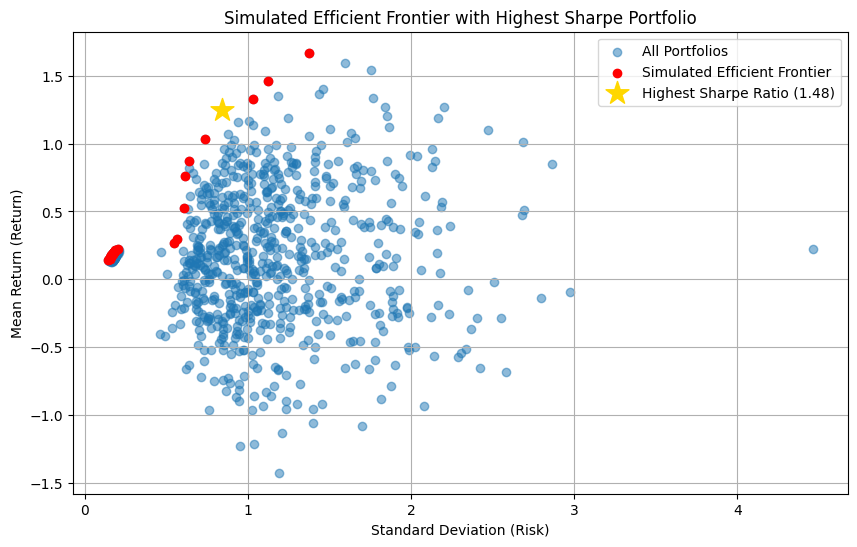

In [15]:
# Plot the efficient frontier portfolios
if not ef_frame.empty:
    plt.figure(figsize=(10, 6))
    plt.scatter(res2["sd_sample"], res2["mean"], label="All Portfolios", alpha=0.5)
    plt.scatter(ef_frame["sd_sample"], ef_frame["mean"], color='red', label="Simulated Efficient Frontier", zorder=5)

    # Find the portfolio with the highest Sharpe Ratio
    highest_sharpe_portfolio = res2.loc[res2["sharpe"].idxmax()]

    # Highlight the highest Sharpe Ratio portfolio
    plt.scatter(
        highest_sharpe_portfolio["sd_sample"],
        highest_sharpe_portfolio["mean"],
        color='gold',       # Distinct color
        marker='*',         # Star marker
        s=300,              # Larger size
        label=f'Highest Sharpe Ratio ({highest_sharpe_portfolio["sharpe"]:.2f})',
        zorder=10           # Ensure it's on top
    )

    plt.xlabel("Standard Deviation (Risk)")
    plt.ylabel("Mean Return (Return)")
    plt.title("Simulated Efficient Frontier with Highest Sharpe Portfolio")
    plt.legend()
    plt.grid(True)
    plt.savefig("sharpe_ratio_ef.png")
    plt.show()

In [16]:
# save ef_frame to csv for further analysis
ef_frame.to_csv("efficient_frontier_portfolios.csv", index=False)

In [17]:
# Select the relevant columns from the efficient frontier DataFrame
metrics_df = ef_frame[["sharpe", "var_95", "cvar_95"]]

# Calculate the correlation matrix
correlation_matrix = metrics_df.corr()

print("Correlation Matrix between Sharpe Ratio, VaR (95%), and CVaR (95%) for Efficient Frontier Portfolios:")
display(correlation_matrix)

Correlation Matrix between Sharpe Ratio, VaR (95%), and CVaR (95%) for Efficient Frontier Portfolios:


,sharpe,var_95,cvar_95
sharpe,1.000000,0.447222,0.152387
var_95,0.447222,1.000000,0.944294
cvar_95,0.152387,0.944294,1.000000


In [18]:
# Find the portfolio with the highest Sharpe Ratio in the "Long Positions Only" regime
highest_sharpe_long_only = res2[res2["regime"] == "Long Positions Only"].loc[res2[res2["regime"] == "Long Positions Only"]["sharpe"].idxmax()]

print("Highest Sharpe Ratio Portfolio (Long Positions Only Regime):")
display(highest_sharpe_long_only[[f"w{i+1}" for i in range(len(tickers))] + ["sharpe", "mean", "sd_sample"]])

print("\nHighest Sharpe Ratio Portfolio (Shorts OK Regime):")
# We already found this one earlier, but let's display it again for easy comparison
highest_sharpe_shorts_ok = res2.loc[res2["sharpe"].idxmax()]
display(highest_sharpe_shorts_ok[[f"w{i+1}" for i in range(len(tickers))] + ["sharpe", "mean", "sd_sample"]])

# You can also display the weights side-by-side in a DataFrame for easier comparison
comparison_df = pd.DataFrame([highest_sharpe_long_only[[f"w{i+1}" for i in range(len(tickers))]], highest_sharpe_shorts_ok[[f"w{i+1}" for i in range(len(tickers))]]])
comparison_df.index = ["Long Positions Only", "Shorts OK"]
comparison_df.columns = [tickers[i] for i in range(len(tickers))]

print("\nComparison of Weights for Highest Sharpe Ratio Portfolios:")
display(comparison_df)

Highest Sharpe Ratio Portfolio (Long Positions Only Regime):


w1           0.034269
w2           0.057067
w3           0.003427
w4           0.043191
w5            0.05181
w6           0.069461
w7           0.003388
w8            0.05581
w9           0.038845
w10          0.060885
w11           0.06031
w12          0.012368
w13           0.01513
w14          0.040946
w15          0.035612
w16          0.055052
w17          0.083412
w18           0.03576
w19          0.058644
w20          0.004559
w21          0.000536
w22          0.020113
w23          0.027273
w24          0.008735
w25          0.023209
w26          0.008876
w27          0.026523
w28          0.002643
w29           0.04731
w30           0.01484
sharpe       1.154668
mean         0.212912
sd_sample    0.184393
Name: 410, dtype: object


Highest Sharpe Ratio Portfolio (Shorts OK Regime):


w1          -0.531499
w2           0.875178
w3           0.094141
w4          -0.565186
w5           0.145389
w6          -0.680083
w7           0.624449
w8          -0.245971
w9          -0.371348
w10          0.404292
w11          0.798458
w12          0.903907
w13         -0.423875
w14         -0.327635
w15          0.875402
w16           0.79845
w17          0.404804
w18          0.223635
w19         -0.864666
w20         -0.646026
w21         -0.703684
w22          0.373841
w23           -0.3445
w24          0.246228
w25           0.47447
w26         -0.613253
w27         -0.065391
w28          0.262959
w29          0.233568
w30         -0.356058
sharpe       1.481604
mean         1.246659
sd_sample    0.841425
Name: 747, dtype: object


Comparison of Weights for Highest Sharpe Ratio Portfolios:


,AAPL,ABBV,AMD,AMZN,AVGO,CME,COST,FDIVX,FXY,GLD,...,SCHD,SLV,SPLB,TLT,VDE,VEA,VWO,VYM,WMT,XOM
Long Positions Only,0.034269,0.057067,0.003427,0.043191,0.051810,0.069461,0.003388,0.055810,0.038845,0.060885,...,0.000536,0.020113,0.027273,0.008735,0.023209,0.008876,0.026523,0.002643,0.047310,0.014840
Shorts OK,-0.531499,0.875178,0.094141,-0.565186,0.145389,-0.680083,0.624449,-0.245971,-0.371348,0.404292,...,-0.703684,0.373841,-0.344500,0.246228,0.474470,-0.613253,-0.065391,0.262959,0.233568,-0.356058


In [19]:
comparison_df.transpose().to_csv("highest_sharpe_portfolio_comparison.csv", index=True)